In [1]:
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from jax import vmap
import jax.numpy as np
from jax.random import PRNGKey
from jax.config import config
config.update("jax_enable_x64", True)

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

import numpy as onp

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

# Bài tập chương 3

### The Easy problems use the samples from the posterior distribution for the globe tossing example. This code will give you a specific set of samples, so that you can check your answers exactly.

In [2]:
p_grid = np.linspace(start=0, stop=1, num=1000)
prior = np.repeat(1, 1000)
likelihood = np.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
posterior = likelihood * prior
posterior = posterior / np.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(PRNGKey(100), (10000,))]

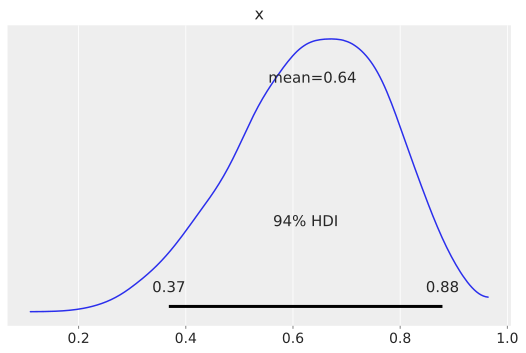

In [3]:
az.plot_posterior(onp.array(samples));

#### 3E1. How much posterior probability lies below p = 0.2?

In [4]:
np.sum(samples<0.2) / len(samples)

DeviceArray(0.0007, dtype=float64)

#### 3E2. How much posterior probability lies above p = 0.8?

In [5]:
np.sum(samples>0.8)/len(samples)

DeviceArray(0.1172, dtype=float64)

#### 3E3. How much posterior probability lies between p = 0.2 and p = 0.8?

In [6]:
np.sum((samples>0.2) &(samples<0.8))/len(samples)

DeviceArray(0.8821, dtype=float64)

#### 3E4. 20% of the posterior probability lies below which value of p?

In [7]:
np.quantile(samples , (0.2))

DeviceArray(0.51751752, dtype=float64)

#### 3E5. 20% of the posterior probability lies above which value of p?

In [8]:
np.quantile(samples , (0.8))

DeviceArray(0.76076076, dtype=float64)

#### 3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [9]:
hpdi(samples, 0.66)

array([0.52052052, 0.78978979])

#### 3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [10]:
np.quantile(samples, (0.17, 1-0.17))

DeviceArray([0.4994995 , 0.77377377], dtype=float64)

#### 3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

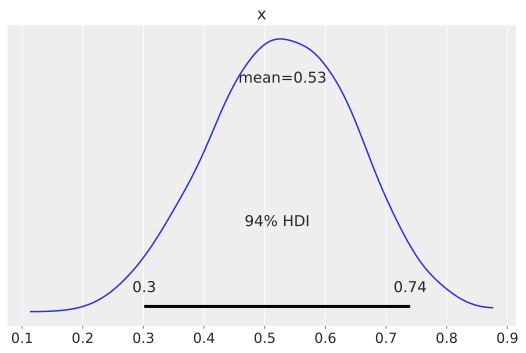

In [11]:
p_grid = np.linspace(start=0, stop=1, num=1000)
prior = np.repeat(1, 1000)
likelihood = np.exp(dist.Binomial(total_count=15, probs=p_grid).log_prob(8))
posterior = likelihood * prior
posterior = posterior / np.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(PRNGKey(100), (10000,))]

az.plot_posterior(onp.array(samples));

In [12]:
samples

DeviceArray([0.56356356, 0.64364364, 0.39339339, ..., 0.43043043,
             0.34734735, 0.1971972 ], dtype=float64)

#### 3M2. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.

In [13]:
hpdi(samples, 0.9)

array([0.34234234, 0.72972973])

#### 3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?

In [14]:
posterior_predictive_samples = dist.Binomial(total_count=15, probs=samples).sample(PRNGKey(0))
np.sum(posterior_predictive_samples==8) / len(posterior_predictive_samples)

DeviceArray(0.1456, dtype=float64)

In [15]:
sum(posterior_predictive_samples == 10)

1159

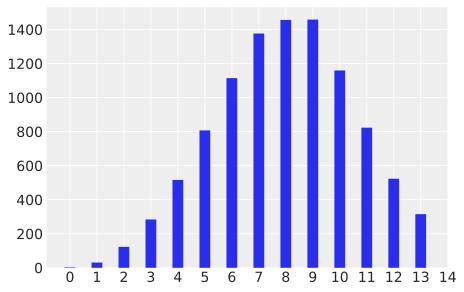

In [16]:
plt.hist(posterior_predictive_samples, bins=np.arange(15),align='left',rwidth=0.4)
plt.xticks(np.arange(15));

#### 3M4. Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [17]:
posterior_predictive_samples = dist.Binomial(total_count=9, probs=samples).sample(PRNGKey(0))
np.sum(posterior_predictive_samples==6) / len(posterior_predictive_samples)

DeviceArray(0.1795, dtype=float64)

#### 3M5. Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (using both priors) to the true value p = 0.7.

In [18]:
p_grid = np.linspace(start=0, stop=1, num=1000)
prior = np.where(p_grid<0.5, 0, 1)
likelihood = np.exp(dist.Binomial(total_count=15, probs=p_grid).log_prob(8))
posterior = likelihood * prior
posterior = posterior / np.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(PRNGKey(10), (10000,))]

print("90% HPDI=", hpdi(samples, 0.9))
posterior_predictive_samples = dist.Binomial(total_count=15, probs=samples).sample(PRNGKey(0))
print("Prob of observing 8 water in 15 tosses", np.sum(posterior_predictive_samples==8) / len(posterior_predictive_samples))
posterior_predictive_samples = dist.Binomial(total_count=9, probs=samples).sample(PRNGKey(0))
print("Prob of observing 6 water in 9 tosses", np.sum(posterior_predictive_samples==6) / len(posterior_predictive_samples))

90% HPDI= [0.5005005  0.71271271]
Prob of observing 8 water in 15 tosses 0.1613
Prob of observing 6 water in 9 tosses 0.2373


(0.0, 1.0)

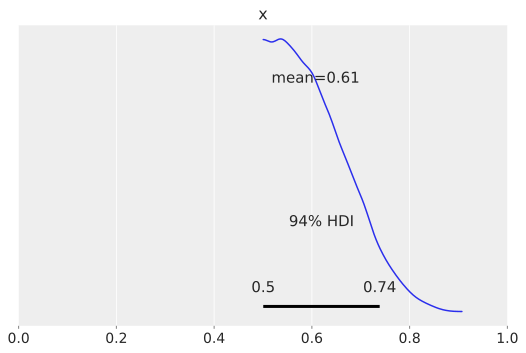

In [19]:
az.plot_posterior(onp.array(samples))
plt.xlim(0,1)

-> With the new prior, the mean is closer to the true parameter (0.7), which is a good thing.

#### 3M6. Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

In [20]:
# I'd like to use flat prior so that posterior == likelihood
# let's try likelihood sampling
def dst_pct_posterior(tosses, p=0.7, sample_size=1000, lower_bound=0.005, upper_bound=0.995, rng=1):
    llh_samp = dist.Binomial(total_count=tosses, probs=p).sample(PRNGKey(rng), (sample_size,))
    posterior_samp = llh_samp / tosses
    d = np.quantile(posterior_samp, upper_bound) - np.quantile(posterior_samp, lower_bound)
    pct = int( (upper_bound - lower_bound)*100 )
    print(f"Distance of {pct}th percentile with {tosses} tosses= {d}")
    return d

In [21]:
# let's try with 10000 tosses and true_p=0.7
dst_pct_posterior(10000);

Distance of 99th percentile with 10000 tosses= 0.02390099999999995


In [22]:
# it's overkill. Let's try fewer tosses.
dst_pct_posterior(1000);

Distance of 99th percentile with 1000 tosses= 0.07100499999999998


In [23]:
# It's seem like we need to increase the number of tosses
for tosses in range(1000, 10000, 100):
    d = dst_pct_posterior(tosses)
    if d <= 0.05:
        print("end with number of tosses =", tosses)
        break

Distance of 99th percentile with 1000 tosses= 0.07100499999999998
Distance of 99th percentile with 1100 tosses= 0.06909545454545452
Distance of 99th percentile with 1200 tosses= 0.06752500000000006
Distance of 99th percentile with 1300 tosses= 0.06309230769230778
Distance of 99th percentile with 1400 tosses= 0.06143571428571426
Distance of 99th percentile with 1500 tosses= 0.060006666666666764
Distance of 99th percentile with 1600 tosses= 0.059374999999999956
Distance of 99th percentile with 1700 tosses= 0.05589411764705887
Distance of 99th percentile with 1800 tosses= 0.053338888888888936
Distance of 99th percentile with 1900 tosses= 0.052636842105263204
Distance of 99th percentile with 2000 tosses= 0.052509999999999946
Distance of 99th percentile with 2100 tosses= 0.04905952380952372
end with number of tosses = 2100


In [24]:
for tosses in range(1000, 10000, 100):
    d = dst_pct_posterior(tosses, p=0.4, rng=10)
    if d <= 0.05:
        print("end with number of tosses =", tosses)
        break

Distance of 99th percentile with 1000 tosses= 0.073015
Distance of 99th percentile with 1100 tosses= 0.07274090909090908
Distance of 99th percentile with 1200 tosses= 0.07002916666666664
Distance of 99th percentile with 1300 tosses= 0.07
Distance of 99th percentile with 1400 tosses= 0.06787142857142858
Distance of 99th percentile with 1500 tosses= 0.06067666666666671
Distance of 99th percentile with 1600 tosses= 0.06188437499999999
Distance of 99th percentile with 1700 tosses= 0.0600235294117647
Distance of 99th percentile with 1800 tosses= 0.06000833333333333
Distance of 99th percentile with 1900 tosses= 0.05738157894736845
Distance of 99th percentile with 2000 tosses= 0.05850749999999999
Distance of 99th percentile with 2100 tosses= 0.052871428571428625
Distance of 99th percentile with 2200 tosses= 0.0540954545454545
Distance of 99th percentile with 2300 tosses= 0.04957391304347819
end with number of tosses = 2300


### I think the number of tosses should be around 2300

#### Hard. The Hard problems here all use the data below. These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.

In [25]:
birth1 = [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
          0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
          0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
          0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
          1, 1, 1, 0, 1, 1, 1, 1]
birth2 = [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
          1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
          1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
          0, 1, 1, 1, 0, 0, 0, 0]

So for example, the first family in the data reported a boy (1) and then a girl (0). The second family reported a girl (0) and then a boy (1). The third family reported two girls.

#### 3H1. Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?

In [26]:
p_grid = np.linspace(0, 1, 100)
prior = np.repeat(1, 100)
likelihood_dist = dist.Binomial(total_count=len(birth1) + len(birth2), probs=p_grid)
count_boy = sum(birth1) + sum(birth2)
likelihood = np.exp(likelihood_dist.log_prob(count_boy))

unstd_posterior = prior*likelihood
posterior = unstd_posterior/np.sum(unstd_posterior)

count_boy

111

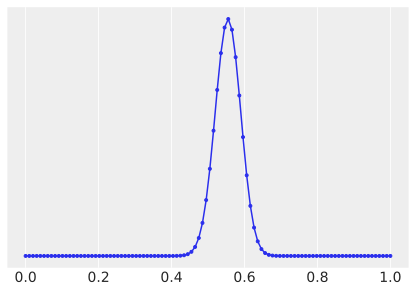

In [27]:
plt.plot(p_grid, posterior, ".-");
plt.yticks([]);

In [28]:
p_grid[np.argmax(posterior)]

DeviceArray(0.55555556, dtype=float64)

#### 3H2. Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior density intervals.

In [29]:
posterior_samples = p_grid[dist.Categorical(probs=posterior).sample(PRNGKey(100), (10000,))]

In [30]:
for i in 0.5, 0.89, 0.97:
    print(f"HPDI {int(i*100)}% =", hpdi(posterior_samples, prob=i))

HPDI 50% = [0.52525253 0.56565657]
HPDI 89% = [0.48484848 0.5959596 ]
HPDI 97% = [0.46464646 0.61616162]


#### 3H3. Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to visualize the simulations, but the dens command (part of the rethinking package) is probably the easiest way in this case. Does it look like the model fits the data well? That is, does the distribution of predictions include the actual observation as a central, likely outcome?

In [31]:
posterior_predictive_samples = dist.Binomial(total_count=200, probs=posterior_samples).sample(PRNGKey(0))
posterior_predictive_samples

DeviceArray([113., 107., 104., ...,  99., 103.,  81.], dtype=float64)

In [32]:
posterior_predictive_samples.shape

(10000,)

(60.0, 160.0)

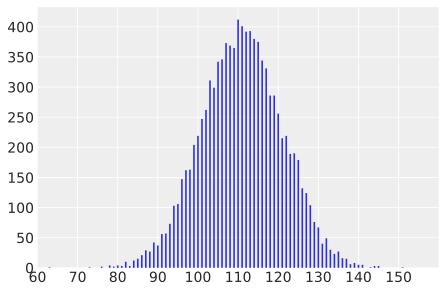

In [33]:
plt.hist(posterior_predictive_samples, bins=np.arange(200),align='left',rwidth=0.4)
plt.xticks(np.arange(50,160,10));
plt.xlim(60,160)

In [34]:
np.median(posterior_predictive_samples)

DeviceArray(111., dtype=float64)

#### 3H4. Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys in the first births, birth1. How does the model look in this light?

In [35]:
posterior_predictive_samples_100birth = dist.Binomial(total_count=100, probs=posterior_samples).sample(PRNGKey(0))
posterior_predictive_samples_100birth

DeviceArray([57., 58., 57., ..., 49., 47., 48.], dtype=float64)

In [36]:
np.median(posterior_predictive_samples_100birth)

DeviceArray(55., dtype=float64)

In [37]:
np.sum(birth1)

DeviceArray(51, dtype=int64)

-> the model is different from birth1, more toward higher value of p.

#### 3H5. The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts of boys to only those second births that followed girls. To do this correctly, you need to count the number of first borns who were girls and simulate that many births, 10,000 times. Compare the counts of boys in your simulations to the actual observed count of boys following girls. How does the model look in this light? Any guesses what is going on in these data?

In [38]:
birth2_followed_girl = np.where(np.array(birth1)==0, np.array(birth2), 0)
birth2_followed_girl

DeviceArray([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
             0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
             1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
             1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],            dtype=int64)

In [39]:
boys_in_birth2_followed_girl = np.sum(birth2_followed_girl)
boys_in_birth2_followed_girl

DeviceArray(39, dtype=int64)

In [40]:
# simulate first 100 birth
sim_birth1 = dist.Bernoulli(probs=posterior_samples).sample(PRNGKey(0), (100,)).T.astype(np.float32)
sim_birth1

DeviceArray([[0., 0., 1., ..., 0., 0., 0.],
             [1., 0., 1., ..., 1., 0., 1.],
             [0., 1., 1., ..., 1., 0., 1.],
             ...,
             [1., 0., 1., ..., 1., 0., 1.],
             [0., 1., 0., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 0., 0.]], dtype=float32)

In [41]:
sim_birth1.shape

(10000, 100)

In [42]:
# now simulate another 100 birth
sim_birth2 = dist.Bernoulli(probs=posterior_samples).sample(PRNGKey(123), (100,)).T.astype(np.float32)
sim_birth2

DeviceArray([[0., 1., 1., ..., 0., 0., 0.],
             [0., 0., 1., ..., 1., 0., 1.],
             [0., 0., 1., ..., 1., 1., 0.],
             ...,
             [1., 1., 1., ..., 1., 0., 0.],
             [0., 0., 0., ..., 1., 1., 0.],
             [1., 1., 1., ..., 0., 0., 1.]], dtype=float32)

In [43]:
sim_birth2_followed_girl = np.where(sim_birth1==0, sim_birth2, 0)
sim_birth2_followed_girl

DeviceArray([[0., 1., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 1., 0.],
             ...,
             [0., 1., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [44]:
boys_in_sim_birth2_followed_girl = np.sum(sim_birth2_followed_girl, axis=1)
boys_in_sim_birth2_followed_girl

DeviceArray([28., 22., 18., ..., 28., 19., 22.], dtype=float32)

In [45]:
boys_in_sim_birth2_followed_girl.shape

(10000,)

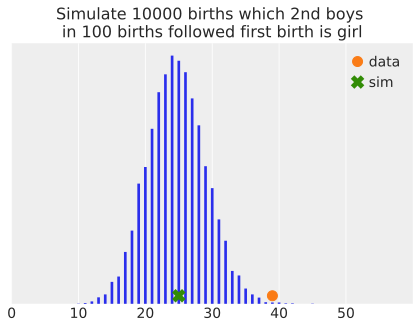

In [46]:
plt.hist(boys_in_sim_birth2_followed_girl, bins=np.arange(0,100),align='left',rwidth=0.4)
plt.xticks(np.arange(0, 60,10));
plt.xlim(0, 60)
plt.plot(boys_in_birth2_followed_girl,30,marker="o", markersize=10, label="data")
plt.plot(np.median(boys_in_sim_birth2_followed_girl),30,marker="x", markersize=10, markeredgewidth=5, label="sim")
plt.title("Simulate 10000 births which 2nd boys \nin 100 births followed first birth is girl")
plt.yticks([])
plt.legend(handlelength=0);

-> In the data, the count of boys in 2nd birth followed female first borns is abnormally high. I think people were using birth-control methods when the first birth is a girl.  
So the count of boy in 2nd birth is dependent on whether the first child is a girl.